## Project Methodology ##

Importing all the Packages and libraries that would be required for the Data analysis Project.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests
import json # library to handle JSON files

#Use geopy library to get the latitude and longitude values of Toronto City
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

#!pip install folium
import folium # map rendering library
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


**_Using Beautiful Soup to scrap and extract Tonto City Zip Code information._**

In [6]:
tor_zip_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(tor_zip_url, 'xml')

table=soup.find('table')
column_names = ['Postal code','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [7]:
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [8]:
df.head()

Postal code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

## Data Cleansing ##

In [9]:
# check names of indexes for which Borough column has value "Not assigned"
indexNames = df[ df['Borough'] =='Not assigned'].index

# Delete the row indexes from dataFrame
df.drop(indexNames , inplace=True)
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
result = df.groupby(['Postal code','Borough'], sort=False).agg( ', '.join)
df_new=result.reset_index()
df_new.head(10)

Postal code           Borough                                 Neighborhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
5         M9A         Etobicoke      Islington Avenue, Humber Valley Village
6         M1B       Scarborough                               Malvern, Rouge
7         M3B        North York                                    Don Mills
8         M4B         East York              Parkview Hill, Woodbine Gardens
9         M5B  Downtown Toronto                     Garden District, Ryerson

**_Creating a combined Dataframe with Postal Codes and Latitude and Longitude information, by merging the scraped data with Geospatial co-ordinates csv we have_**

In [14]:
dfgeo=pd.read_csv("C:/Users/sanke/Downloads/Geospatial_Coordinates.csv")

dfgeo.columns=['Postal code','Latitude','Longitude']
df_toronto = pd.merge(df_new,
                 dfgeo[['Postal code','Latitude', 'Longitude']],
                 on='Postal code')
df_toronto.head()

Postal code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

**_Creating function to fetch latitudes and longitudes for given location_**

In [15]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="my_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

**_Specifying the Foursquare API Client details for calls made through the Project_**

In [16]:
    CLIENT_ID = 'MOFCLWFI5MOZ0AH2JJBAW3LZ3EVG2J1GDHAOMMRVCMGBO1OS'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='21XYGON4S4GRID4CEOLLUSSVGVD0U1F4TL0WLU0PV2AKVJRA' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180604' # Foursquare API version

**_Creating function to fetch Vemue Details for given location_**

In [13]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

**_Creating function to fetch Tips for Restaurant Venues_**

In [17]:
def get_venue_details(venue_id):
   
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

**_Creating function to extract the Venues related Data_**

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Exploratory Analysis of the Data we will use for this Project.**

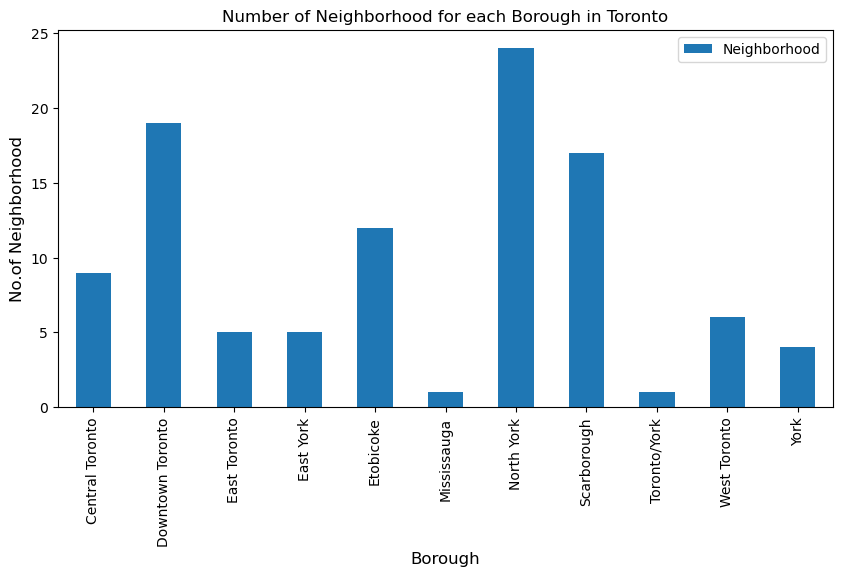

In [19]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
df_toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As per the above bar chart **North York Borough**  has highest number of neighborhoods.

In [20]:
# Calling FourSquare API to find the Indian Restaurants within Toronto City to initiate our research.

column_names=['Borough', 'Neighborhood', 'ID','Name']
ind_res_toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_toronto.values.tolist():
    Postalcode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    ind_res=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_toronto),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(ind_res)))
    for restaurant_detail in ind_res.values.tolist():
        id, name , category=restaurant_detail
        ind_res_toronto = ind_res_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 103 ) Indian Restaurants in Parkwoods, North York:0
( 2 / 103 ) Indian Restaurants in Victoria Village, North York:0
( 3 / 103 ) Indian Restaurants in Regent Park, Harbourfront, Downtown Toronto:2
( 4 / 103 ) Indian Restaurants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Indian Restaurants in Queen's Park, Ontario Provincial Government, Downtown Toronto:1
( 6 / 103 ) Indian Restaurants in Islington Avenue, Humber Valley Village, Etobicoke:0
( 7 / 103 ) Indian Restaurants in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Indian Restaurants in Don Mills, North York:1
( 9 / 103 ) Indian Restaurants in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Indian Restaurants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Indian Restaurants in Glencairn, North York:0
( 12 / 103 ) Indian Restaurants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Indian Restaurants in Rouge Hill, Port Union, Highland Cree

( 103 / 103 ) Indian Restaurants in Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West, Etobicoke:0


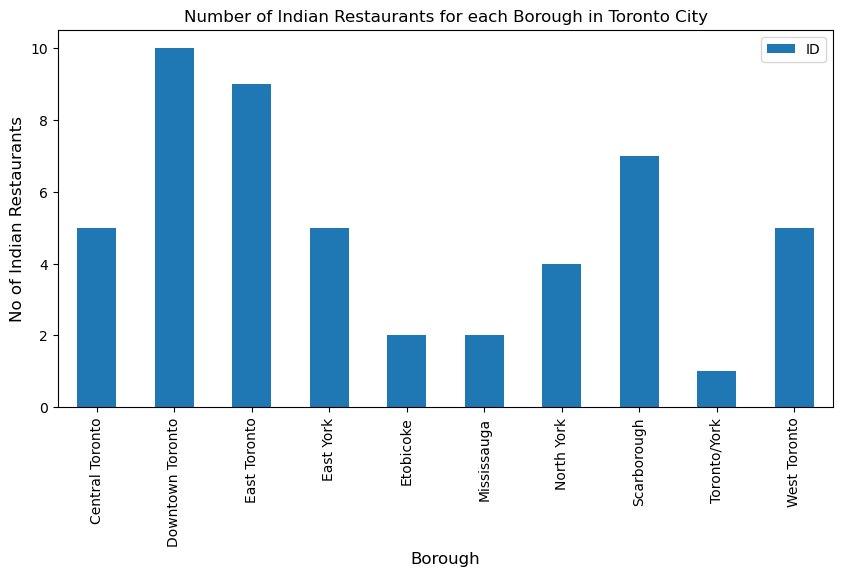

In [21]:
#EXploring the number of Indian Restaurants in Each Borough through Bar Plot

plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Indian Restaurants for each Borough in Toronto City')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No of Indian Restaurants', fontsize=12)
ind_res_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

As per the above bar chart **Downtown Toronto Borough** has highest number of Indian restaurants.

In [22]:
#Segragating the restaurants on basis of boroughs
ind_res_toronto.groupby('Borough')['ID'].count()

Borough
Central Toronto      5
Downtown Toronto    10
East Toronto         9
East York            5
Etobicoke            2
Mississauga          2
North York           4
Scarborough          7
Toronto/York         1
West Toronto         5
Name: ID, dtype: int64

In [23]:
#Segragating the restaurants on basis of Neighborhood
ind_res_toronto.groupby('Neighborhood')['ID'].count()

Neighborhood
Agincourt                                                       1
Bedford Park, Lawrence Manor East                               1
Brockton, Parkdale Village, Exhibition Place                    2
Canada Post Gateway Processing Centre                           2
Cedarbrae                                                       2
Christie                                                        2
Church and Wellesley                                            2
Davisville                                                      3
Don Mills                                                       2
Dorset Park, Wexford Heights, Scarborough Town Centre           2
East Toronto, Broadview North (Old East York)                   1
Harbourfront East, Union Station, Toronto Islands               1
High Park, The Junction South                                   2
India Bazaar, The Beaches West                                  6
Leaside                                                        

In [25]:
#Filtering the neighborhoods to Top 5 based on the above data
df_tor_top_5_Neighbor = ind_res_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).to_frame(name='Total')
df_tor_top_5_Neighbor= df_tor_top_5_Neighbor.reset_index()
df_tor_top_5_Neighbor.rename(index=str, columns={"index": "Neighborhood", "Total": "Total Indian Restaurant"}, inplace=True)
df_tor_top_5_Neighbor

Neighborhood  Total Indian Restaurant
0                India Bazaar, The Beaches West                        6
1                                    Davisville                        3
2                              Thorncliffe Park                        3
3  Brockton, Parkdale Village, Exhibition Place                        2
4         Canada Post Gateway Processing Centre                        2

**India Bazaar** and **The Beaches West** have highest number of Indian restaurans(6).

In [26]:
# Trying to find which borough the India Bazaar and The Beaches West belong
ind_res_toronto[ind_res_toronto['Neighborhood']=='India Bazaar, The Beaches West']

Borough                    Neighborhood                        ID  \
21  East Toronto  India Bazaar, The Beaches West  4ae0c7a8f964a520638221e3   
22  East Toronto  India Bazaar, The Beaches West  4afc9816f964a520312422e3   
23  East Toronto  India Bazaar, The Beaches West  4bac30a2f964a52018ea3ae3   
24  East Toronto  India Bazaar, The Beaches West  4bbcc0efa0a0c9b60ebd1a0f   
25  East Toronto  India Bazaar, The Beaches West  4d8d278a1d06b1f712942a3b   
26  East Toronto  India Bazaar, The Beaches West  4edd30c09adfe5cbe2818dc4   

                           Name  
21                 Udupi Palace  
22                    Motimahal  
23             Bombay Chowpatty  
24                  Haandi 2000  
25                      Gautama  
26  Lahori Taste & Burger House

**_Both the neighborhoods belng to East Toronto Borough_**

In [27]:
#Fetching the Postal Codes and Co-ordinates for Top 5 neighborhoods(with indian Restaurants)
df_tor_5 = df_tor_top_5_Neighbor.join(df_toronto.set_index("Neighborhood"), on="Neighborhood")

print(df_tor_5.shape)
df_tor_5.head()

(5, 6)


Neighborhood  Total Indian Restaurant  \
0                India Bazaar, The Beaches West                        6   
1                                    Davisville                        3   
2                              Thorncliffe Park                        3   
3  Brockton, Parkdale Village, Exhibition Place                        2   
4         Canada Post Gateway Processing Centre                        2   

  Postal code          Borough   Latitude  Longitude  
0         M4L     East Toronto  43.668999 -79.315572  
1         M4S  Central Toronto  43.704324 -79.388790  
2         M4H        East York  43.705369 -79.349372  
3         M6K     West Toronto  43.636847 -79.428191  
4         M7R      Mississauga  43.636966 -79.615819

In [28]:
#Creating map of top 5 Neighborhood having Indian Restaurant using the above Dataframe with Geospatial Co-ordinates

lat_tor = df_toronto['Latitude'].mean()
long_tor = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_tor, long_tor))


Tor_5_map = folium.Map(location=[lat_tor, long_tor], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_tor_5['Latitude'], df_tor_5['Longitude'], 
                           df_tor_5['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='Orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6).add_to(Tor_5_map)  
    
Tor_5_map



The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


_Now That we have found Borough and Neighborhood with Maximum Indian Restaurant for **Quantitative Analysis**._
_We will now do **Qualitative Analysis**, again by calling **Foursquare API** to obtain ratings for Indian Restaurants._

In [29]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
ind_res_tor_top=pd.DataFrame(columns=column_names)
count=1


for row in ind_res_toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ind_res_toronto),')','processed')
    ind_res_tor_top = ind_res_tor_top.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4af9a379f964a520c91222e3  Bombay Palace     14     7.7    13
( 1 / 50 ) processed
                         ID               Name  Likes  Rating  Tips
0  52af6dc5498e33995b0bbf03  Sultan Of Samosas      9     6.8     4
( 2 / 50 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4bedf8b5e24d20a17b567214  Kothur Indian Cuisine     16     8.0    19
( 3 / 50 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5c229362a0215b002cb89eb2
( 4 / 50 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5bacff8d340a58002c39df9e
( 5 / 50 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     7.0     3
( 6 / 50 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b60e4a1f96

In [30]:
# Seeking details of the Dataset extracted
ind_res_tor_top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [31]:
#Sorting the Dataset on the basis of Rating, since, we want to find out neighborhood with maximum rating.
tor_neighbor_rating=ind_res_tor_top.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
tor_neighbor_rating.columns=['Neighborhood','Average Rating']
tor_neighbor_rating.sort_values(['Average Rating'],ascending=False)
tor_neighbor_rating=tor_neighbor_rating[tor_neighbor_rating['Average Rating']>=8.0]
tor_rat_final=tor_neighbor_rating.sort_values(['Average Rating'],ascending=False)
tor_rat_final.head(10)



Neighborhood  Average Rating
5                                       Christie            8.25
21           The Annex, North Midtown, Yorkville            8.20
2   Brockton, Parkdale Village, Exhibition Place            8.00
16   Queen's Park, Ontario Provincial Government            8.00
20                   St. James Town, Cabbagetown            8.00
27                             Wexford, Maryvale            8.00

**Christie** has the Highest Rated Restaurant closely followed by **The Annex, North Midtown and Yorkville**

In [32]:
#Since, we obtained the Neighborhoods, let find the restaurant with max rating
df_rest_rating = tor_rat_final.join(ind_res_tor_top.set_index("Neighborhood"), on="Neighborhood")
df_rest_rating=df_rest_rating.sort_values(['Rating'],ascending=False)
df_rest_rating[['Name','Borough','Neighborhood','Rating']].head()

Name           Borough  \
21   Roti Cuisine of India   Central Toronto   
5   Banjara Indian Cuisine  Downtown Toronto   
2             Mother India      West Toronto   
16   Kothur Indian Cuisine  Downtown Toronto   
20  Butter Chicken Factory  Downtown Toronto   

                                    Neighborhood  Rating  
21           The Annex, North Midtown, Yorkville     8.7  
5                                       Christie     8.6  
2   Brockton, Parkdale Village, Exhibition Place     8.3  
16   Queen's Park, Ontario Provincial Government     8.0  
20                   St. James Town, Cabbagetown     8.0

**Roti Cuisine of India** has the Highest Rating closely followed by **Banjara Indian Cuisine**

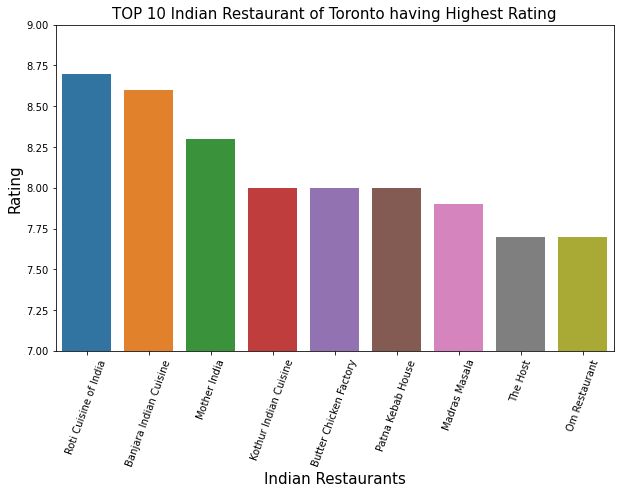

In [33]:
#Visualizing the obtained data through color plot using Seaborn library.
import seaborn as sns
fig = plt.figure(figsize=(10,6))
s=sns.barplot(x="Name", y="Rating", data=df_rest_rating)
s.set_xticklabels(s.get_xticklabels(), rotation=70)
plt.title('TOP 10 Indian Restaurant of Toronto having Highest Rating', fontsize=15)
plt.xlabel("Indian Restaurants", fontsize=15)
plt.ylabel ("Rating", fontsize=15)
plt.ylim(7.0, 9.0)
plt.savefig("TOP_10_Indian_Restaurant.png", dpi=300)
plt.show()

In [34]:
#Exploring the neighborhoods in Detail to utilise our Analysis to create cluster through K-Means
Toronto_Venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])


Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [35]:
Toronto_Venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1             649 Variety       43.754513       -79.331942   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1      Convenience Store  
2      Food & Drink Shop  
3           Hockey Arena  
4  Portuguese Restaurant

**Detailed Analysis of each Neighborhood through One hot Encoding.** 

In [37]:
# one hot encoding
tor_onehot = pd.get_dummies(Toronto_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhoods'] = Toronto_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

print(tor_onehot.shape)
tor_onehot.head()

(2101, 269)


Neighborhoods  Accessories Store  Adult Boutique  Airport  \
0         Parkwoods                  0               0        0   
1         Parkwoods                  0               0        0   
2         Parkwoods                  0               0        0   
3  Victoria Village                  0               0        0   
4  Victoria Village                  0               0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Garage  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0            0          0           0           0       0     0    0   
1            0          0           0           0       0     0    0   
2            0          0           0           0       0     0    0   
3            0          0           0           0       0     0    0   
4            0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Rental / Bike Share  Bike Shop  Bistro  Boat or Ferry  Bookstore  \
0                         0          0       0              0          0   
1                         0          0       0              0          0   
2                         0          0       0              0          0   
3                         0          0       0              0          0   
4                         0          0       0              0          0   

   Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0         0                     0               0        0            0   
1         0                     0               0        0            0   
2         0                     0               0        0            0   
3         0                     0               0        0            0   
4         0                     0               0        0            0

In [38]:
#Grouping the data on basis of neighborhood by calculating mean of frequency of occurence of each category
tor_grouped = tor_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(tor_grouped.shape)
tor_grouped.head()


(95, 269)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Adult Boutique  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0             0.0      0.0                 0.0           0.0             0.0   
1             0.0      0.0                 0.0           0.0             0.0   
2             0.0      0.0                 0.0           0.0             0.0   
3             0.0      0.0                 0.0           0.0             0.0   
4             0.0      0.0                 0.0           0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0              0.0               0.0             0.000000           0.0   
1              0.0               0.0             0.000000           0.0   
2              0.0               0.0             0.000000           0.0   
3              0.0               0.0             0.000000           0.0   
4              0.0               0.0             0.043478           0.0   

   Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       0.0          0.0         0.0                  0.0               0.0   
1       0.0          0.0         0.0                  0.0               0.0   
2       0.0          0.0         0.0                  0.0               0.0   
3       0.0          0.0         0.0                  0.0               0.0   
4       0.0          0.0         0.0                  0.0               0.0   

   Athletics & Sports  Auto Garage  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0                 0.0          0.0        0.0         0.0         0.0     0.0   
1                 0.0          0.0        0.0         0.0         0.0     0.0   
2                 0.0          0.0        0.0         0.0         0.0     0.0   
3                 0.0          0.0        0.0         0.0         0.0     0.0   
4                 0.0          0.0        0.0         0.0         0.0     0.0   

       Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.000000  0.0             0.0               0.0               0.0   
1  0.000000  0.0             0.0               0.0               0.0   
2  0.083333  0.0             0.0               0.0               0.0   
3  0.250000  0.0             0.0               0.0               0.0   
4  0.000000  0.0             0.0               0.0               0.0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                 0.0    0.0              0.0       0.0         0.0   
1                 0.0    0.0              0.0       0.0         0.0   
2                 0.0    0.0              0.0       0.0         0.0   
3                 0.0    0.0              0.0       0.0         0.0   
4                 0.0    0.0              0.0       0.0         0.0   

   Belgian Restaurant  Bike Rental / Bike Share  Bike Shop  Bistro  \
0                 0.0                       0.0        0.0     0.0   
1                 0.0                       0.0        0.0     0.0   
2                 0.0                       0.0        0.0     0.0   
3                 0.0                       0.0        0.0     0.0   
4                 0.0                       0.0        0.0     0.0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0            0.0        0.0       0.0                   0.0            0.25   
1            0.0        0.0       0.0                   0.0            0.00   
2            0.0        0.0       0.0                   0.0            0.00   
3            0.0        0.0       0.0                   0.0            0.00   
4            0.0        0.0 

In [39]:
#Getting relevant data for our research by focusing on Indian Restaurants present with the Neighborhood
ind_res_data = tor_grouped[["Neighborhoods","Indian Restaurant"]]
ind_res_data = ind_res_data.rename(columns={'Neighborhoods':'Neighborhood'})
ind_res_data.head()

Neighborhood  Indian Restaurant
0                                        Agincourt           0.000000
1                           Alderwood, Long Branch           0.000000
2  Bathurst Manor, Wilson Heights, Downsview North           0.000000
3                                  Bayview Village           0.000000
4                Bedford Park, Lawrence Manor East           0.043478

## Clustering Analysis

In [41]:
#Using K-Means clustering to find the best value for K.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ind_res_data.drop(['Neighborhood'], axis=1)
kmeans.fit(X)
kmeans.labels_[0:30]

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

_Defining a function to find the value of K_

In [42]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [43]:
scores = [get_inertia(x) for x in range(2, 25)]

<ipython-input-42-ef2da8e3327a>:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  km.fit(X)
<ipython-input-42-ef2da8e3327a>:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  km.fit(X)
<ipython-input-42-ef2da8e3327a>:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  km.fit(X)
<ipython-input-42-ef2da8e3327a>:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(X)
<ipython-input-42-ef2da8e3327a>:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  km.fit(X)
<ipython-input-42-ef2da8e3327a>:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (17). P

Text(0, 0.5, 'Error')

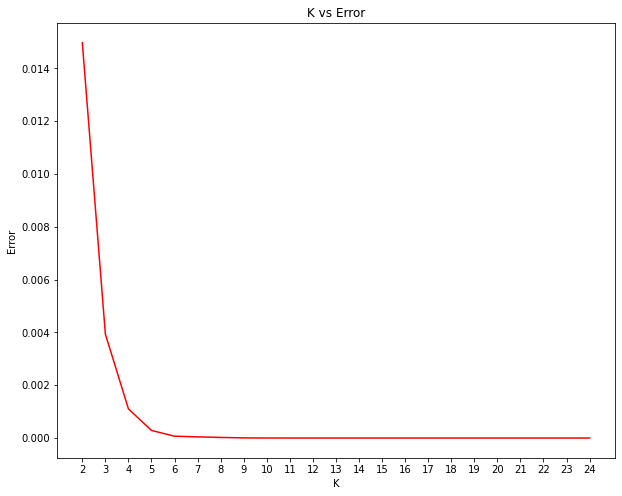

In [44]:
# Plotting a lineplot for finding elbow point
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 25), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 25))
plt.xlabel("K")
plt.ylabel("Error")

**_From the above plot we get value of K=5._**

In [51]:
kclusters = 5

tor_grouped_clustering = ind_res_data.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [52]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
tor_merge = ind_res_data.copy()

# add clustering labels
tor_merge["Cluster Labels"] = kmeans.labels_

In [53]:
tor_merge.head()

Neighborhood  Indian Restaurant  \
0                                        Agincourt           0.000000   
1                           Alderwood, Long Branch           0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North           0.000000   
3                                  Bayview Village           0.000000   
4                Bedford Park, Lawrence Manor East           0.043478   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [54]:
# Adding Geospatial co-ordinates 
tor_merge = tor_merge.join(Toronto_Venues.set_index("Neighborhood"), on="Neighborhood")

tor_merge.head()

Neighborhood  Indian Restaurant  Cluster Labels  \
0               Agincourt                0.0               0   
0               Agincourt                0.0               0   
0               Agincourt                0.0               0   
0               Agincourt                0.0               0   
1  Alderwood, Long Branch                0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                   Commander Arena       43.794867       -79.267989   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0               Skating Rink  
1                Pizza Place

In [55]:
#Sorting the Data on basis of Cluster Labels
tor_merge.sort_values(["Cluster Labels"], inplace=True)
tor_merge.head(20)


Neighborhood  Indian Restaurant  \
0                                     Agincourt                0.0   
63                    Regent Park, Harbourfront                0.0   
63                    Regent Park, Harbourfront                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
63                    Regent Park, Harbourfront                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   
62  Queen's Park, Ontario Provincial Government                0.0   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                0              43.794200              -79.262029   
63               0              43.654260              -79.360636   
63               0              43.654260              -79.360636   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
63               0              43.654260              -79.360636   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   
62               0              43.662301              -79.389494   

                                Venue  Venue Latitude  Venue Longitude  \
0         Panagio's Breakfast & Lunch       43.792370       -79.260203   
63                      Tandem Coffee       43.653559       -79.361809   
63                   Roselle Desserts       43.653447       -79.362017   
62  University of Toronto Arts Centre       43.663605       -79.395159   
62        Understudy Café at Gerstein       43.662308       -79.394098   
62                        Tim Hortons       43.658906       -79.388696   
62                        Tim Hortons       43.659415       -79.391221   
62                   Convocation Hall       43.660828       -79.395245   
62                               SUDS       43.659880       -79.394712   
62                     Hart House Gym       43.664172       -79.394888   
62                          Starbucks       43.660887       -79.393720   
62                        Tim Hortons       43.661038       -79.393797   
62                 Aroma Espresso Bar       43.658928       -79.389903   
63             Cooper Koo Family YMCA       43.653249       -79.358008   
62  

In [61]:
# Filtering the relevant information by only including the Indian Restaurant Data.
tor_merge['Venue Category'].value_counts()['Indian Restaurant']

12

In [63]:
import folium
#Creating Map of Neigborhoods and Indian Restaurants
lat_toronto = df_toronto['Latitude'].mean()
long_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, long_toronto))
map_clusters = folium.Map(location=[lat_toronto, long_toronto], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merge['Neighborhood Latitude'], tor_merge['Neighborhood Longitude'], tor_merge['Neighborhood'], tor_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters


The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [64]:
#Neighborhod per clusters
ind_res_data["Cluster Labels"] = kmeans.labels_
ind_res_data.head()

Neighborhood  Indian Restaurant  \
0                                        Agincourt           0.000000   
1                           Alderwood, Long Branch           0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North           0.000000   
3                                  Bayview Village           0.000000   
4                Bedford Park, Lawrence Manor East           0.043478   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [65]:
#Count of neighborhoods in each cluster.
ind_res_data["Cluster Labels"].value_counts()

0    86
3     5
2     2
4     1
1     1
Name: Cluster Labels, dtype: int64

**_Cluster wise Analysis_**

In [66]:
#Cluster 1
df2 = df[['Borough','Neighborhood']]
C1 = tor_merge.loc[tor_merge['Cluster Labels'] == 0]
df_cl1 = pd.merge(df2, C1, on='Neighborhood')
df_cl1

Borough                                       Neighborhood  \
0           North York                                          Parkwoods   
1           North York                                          Parkwoods   
2           North York                                          Parkwoods   
3           North York                                   Victoria Village   
4           North York                                   Victoria Village   
5           North York                                   Victoria Village   
6           North York                                   Victoria Village   
7     Downtown Toronto                          Regent Park, Harbourfront   
8     Downtown Toronto                          Regent Park, Harbourfront   
9     Downtown Toronto                          Regent Park, Harbourfront   
10    Downtown Toronto                          Regent Park, Harbourfront   
11    Downtown Toronto                          Regent Park, Harbourfront   
12    Downtown Toronto                          Regent Park, Harbourfront   
13    Downtown Toronto                          Regent Park, Harbourfront   
14    Downtown Toronto                          Regent Park, Harbourfront   
15    Downtown Toronto                          Regent Park, Harbourfront   
16    Downtown Toronto                          Regent Park, Harbourfront   
17    Downtown Toronto                          Regent Park, Harbourfront   
18    Downtown Toronto                          Regent Park, Harbourfront   
19    Downtown Toronto                          Regent Park, Harbourfront   
20    Downtown Toronto                          Regent Park, Harbourfront   
21    Downtown Toronto                          Regent Park, Harbourfront   
22    Downtown Toronto                          Regent Park, Harbourfront   
23    Downtown Toronto                          Regent Park, Harbourfront   
24    Downtown Toronto                          Regent Park, Harbourfront   
25    Downtown Toronto                          Regent Park, Harbourfront   
26    Downtown Toronto                          Regent Park, Harbourfront   
27    Downtown Toronto                          Regent Park, Harbourfront   
28    Downtown Toronto                          Regent Park, Harbourfront   
29    Downtown Toronto                          Regent Park, Harbourfront   
30    Downtown Toronto                          Regent Park, Harbourfront   
31    Downtown Toronto                          Regent Park, Harbourfront   
32    Downtown Toronto                          Regent Park, Harbourfront   
33    Downtown Toronto                          Regent Park, Harbourfront   
34    Downtown Toronto                          Regent Park, Harbourfront   
35    Downtown Toronto                          Regent Park, Harbourfront   
36    Downtown Toronto                          Regent Park, Harbourfront   
37    Downtown Toronto                          Regent Park, Harbourfront   
38    Downtown Toronto                          Regent Park, Harbourfront   
39    Downtown Toronto                          Regent Park, Harbourfront   
40    Downtown Toronto                          Regent Park, Harbourfront   
41    Downtown Toronto                          Regent Park, Harbourfront   
42    Downtown Toronto                          Regent Park, Harbourfront   
43    Downtown Toronto                          Regent Park, Harbourfront   
44    Downtown Toronto                          Regent Park, Harbourfront   
45    Downtown Toronto                          Regent Park, Harbourfront   
46    Downtown Toronto                          Regent Park, Harbourfront   
47    Downtown Toronto                          Regent Park, Harbourfront   
48    Downtown Toronto                          Regent Park, Harbourfront   
49    Downtown Toronto                          Regent Park, Harbourfront   
50    Downtown Toronto                          Regent Park, Harbourfront   
51    Downt

In [67]:
#Cluster 2
C2 = tor_merge.loc[tor_merge['Cluster Labels'] == 1]
df_cl2 = pd.merge(df2, C2, on='Neighborhood')
df_cl2

Borough                                       Neighborhood  \
0  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
1  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
2  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
3  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
4  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
5  Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   

   Indian Restaurant  Cluster Labels  Neighborhood Latitude  \
0           0.333333               1               43.75741   
1           0.333333               1               43.75741   
2           0.333333               1               43.75741   
3           0.333333               1               43.75741   
4           0.333333               1               43.75741   
5           0.333333               1               43.75741   

   Neighborhood Longitude                                        Venue  \
0              -79.273304                     Big Al's Pet Supercentre   
1              -79.273304                                      Kairali   
2              -79.273304                           Kim Kim restaurant   
3              -79.273304  Karaikudi Chettinad South Indian Restaurant   
4              -79.273304                             Mill St. Brewery   
5              -79.273304                                  Pho Vietnam   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.759279       -79.278325              Pet Store  
1       43.754915       -79.276945      Indian Restaurant  
2       43.753833       -79.276611     Chinese Restaurant  
3       43.756042       -79.276276      Indian Restaurant  
4       43.759472       -79.271121                Brewery  
5       43.757770       -79.278572  Vietnamese Restaurant

In [68]:
#Cluster 3
C3 = tor_merge.loc[tor_merge['Cluster Labels'] == 2]
df_cl3 = pd.merge(df2, C3, on='Neighborhood')
df_cl3

Borough                         Neighborhood  Indian Restaurant  \
0        North York    Bedford Park, Lawrence Manor East           0.043478   
1        North York    Bedford Park, Lawrence Manor East           0.043478   
2        North York    Bedford Park, Lawrence Manor East           0.043478   
3        North York    Bedford Park, Lawrence Manor East           0.043478   
4        North York    Bedford Park, Lawrence Manor East           0.043478   
5        North York    Bedford Park, Lawrence Manor East           0.043478   
6        North York    Bedford Park, Lawrence Manor East           0.043478   
7        North York    Bedford Park, Lawrence Manor East           0.043478   
8        North York    Bedford Park, Lawrence Manor East           0.043478   
9        North York    Bedford Park, Lawrence Manor East           0.043478   
10       North York    Bedford Park, Lawrence Manor East           0.043478   
11       North York    Bedford Park, Lawrence Manor East           0.043478   
12       North York    Bedford Park, Lawrence Manor East           0.043478   
13       North York    Bedford Park, Lawrence Manor East           0.043478   
14       North York    Bedford Park, Lawrence Manor East           0.043478   
15       North York    Bedford Park, Lawrence Manor East           0.043478   
16       North York    Bedford Park, Lawrence Manor East           0.043478   
17       North York    Bedford Park, Lawrence Manor East           0.043478   
18       North York    Bedford Park, Lawrence Manor East           0.043478   
19       North York    Bedford Park, Lawrence Manor East           0.043478   
20       North York    Bedford Park, Lawrence Manor East           0.043478   
21       North York    Bedford Park, Lawrence Manor East           0.043478   
22       North York    Bedford Park, Lawrence Manor East           0.043478   
23  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
24  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
25  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
26  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
27  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
28  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
29  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
30  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
31  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
32  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
33  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
34  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
35  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
36  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
37  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
38  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
39  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
40  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
41  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   
42  Central Toronto  The Annex, North Midtown, Yorkville           0.050000   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                2              43.733283              -79.419750   
1                2              43.733283              -79.419750   
2                2              43.733283              -79.419750   
3                2              43.733283              -79.419750   
4                2              43.733283              -79.419750   
5                2              43.733283              -79.419750   
6                2              43.733283           

In [69]:
#Cluster 4
C4 = tor_merge.loc[tor_merge['Cluster Labels'] == 3]
df_cl4 = pd.merge(df2, C4, on='Neighborhood')
df_cl4

Borough                  Neighborhood  Indian Restaurant  \
0    Downtown Toronto            Central Bay Street           0.016667   
1    Downtown Toronto            Central Bay Street           0.016667   
2    Downtown Toronto            Central Bay Street           0.016667   
3    Downtown Toronto            Central Bay Street           0.016667   
4    Downtown Toronto            Central Bay Street           0.016667   
5    Downtown Toronto            Central Bay Street           0.016667   
6    Downtown Toronto            Central Bay Street           0.016667   
7    Downtown Toronto            Central Bay Street           0.016667   
8    Downtown Toronto            Central Bay Street           0.016667   
9    Downtown Toronto            Central Bay Street           0.016667   
10   Downtown Toronto            Central Bay Street           0.016667   
11   Downtown Toronto            Central Bay Street           0.016667   
12   Downtown Toronto            Central Bay Street           0.016667   
13   Downtown Toronto            Central Bay Street           0.016667   
14   Downtown Toronto            Central Bay Street           0.016667   
15   Downtown Toronto            Central Bay Street           0.016667   
16   Downtown Toronto            Central Bay Street           0.016667   
17   Downtown Toronto            Central Bay Street           0.016667   
18   Downtown Toronto            Central Bay Street           0.016667   
19   Downtown Toronto            Central Bay Street           0.016667   
20   Downtown Toronto            Central Bay Street           0.016667   
21   Downtown Toronto            Central Bay Street           0.016667   
22   Downtown Toronto            Central Bay Street           0.016667   
23   Downtown Toronto            Central Bay Street           0.016667   
24   Downtown Toronto            Central Bay Street           0.016667   
25   Downtown Toronto            Central Bay Street           0.016667   
26   Downtown Toronto            Central Bay Street           0.016667   
27   Downtown Toronto            Central Bay Street           0.016667   
28   Downtown Toronto            Central Bay Street           0.016667   
29   Downtown Toronto            Central Bay Street           0.016667   
30   Downtown Toronto            Central Bay Street           0.016667   
31   Downtown Toronto            Central Bay Street           0.016667   
32   Downtown Toronto            Central Bay Street           0.016667   
33   Downtown Toronto            Central Bay Street           0.016667   
34   Downtown Toronto            Central Bay Street           0.016667   
35   Downtown Toronto            Central Bay Street           0.016667   
36   Downtown Toronto            Central Bay Street           0.016667   
37   Downtown Toronto            Central Bay Street           0.016667   
38   Downtown Toronto            Central Bay Street           0.016667   
39   Downtown Toronto            Central Bay Street           0.016667   
40   Downtown Toronto            Central Bay Street           0.016667   
41   Downtown Toronto            Central Bay Street           0.016667   
42   Downtown Toronto            Central Bay Street           0.016667   
43   Downtown Toronto            Central Bay Street           0.016667   
44   Downtown Toronto            Central Bay Street           0.016667   
45   Downtown Toronto            Central Bay Street           0.016667   
46   Downtown Toronto            Central Bay Street           0.016667   
47   Downtown Toronto            Central Bay Street           0.016667   
48   Downtown Toronto            Central Bay Street           0.016667   
49   Downtown Toronto            Central Bay Street           0.016667   
50   Downtown Toronto            Central Bay Street           0.016667   
51   Downtown Toronto            Central Bay Street           0.016667   
52   Downtown Toronto            Central Bay Street           0.016667   
53   Downtown Toro

In [70]:
#Cluster 5
C5 = tor_merge.loc[tor_merge['Cluster Labels'] == 4]
df_cl5 = pd.merge(df2, C5, on='Neighborhood')
df_cl5

Borough      Neighborhood  Indian Restaurant  Cluster Labels  \
0   East York  Thorncliffe Park           0.095238               4   
1   East York  Thorncliffe Park           0.095238               4   
2   East York  Thorncliffe Park           0.095238               4   
3   East York  Thorncliffe Park           0.095238               4   
4   East York  Thorncliffe Park           0.095238               4   
5   East York  Thorncliffe Park           0.095238               4   
6   East York  Thorncliffe Park           0.095238               4   
7   East York  Thorncliffe Park           0.095238               4   
8   East York  Thorncliffe Park           0.095238               4   
9   East York  Thorncliffe Park           0.095238               4   
10  East York  Thorncliffe Park           0.095238               4   
11  East York  Thorncliffe Park           0.095238               4   
12  East York  Thorncliffe Park           0.095238               4   
13  East York  Thorncliffe Park           0.095238               4   
14  East York  Thorncliffe Park           0.095238               4   
15  East York  Thorncliffe Park           0.095238               4   
16  East York  Thorncliffe Park           0.095238               4   
17  East York  Thorncliffe Park           0.095238               4   
18  East York  Thorncliffe Park           0.095238               4   
19  East York  Thorncliffe Park           0.095238               4   
20  East York  Thorncliffe Park           0.095238               4   

    Neighborhood Latitude  Neighborhood Longitude                       Venue  \
0               43.705369              -79.349372                Leaside park   
1               43.705369              -79.349372                    Fit4Less   
2               43.705369              -79.349372                        LCBO   
3               43.705369              -79.349372                   Dollarama   
4               43.705369              -79.349372              Kandahar Kabab   
5               43.705369              -79.349372                     Quiznos   
6               43.705369              -79.349372                 Food Basics   
7               43.705369              -79.349372                Swiss Chalet   
8               43.705369              -79.349372                         A&W   
9               43.705369              -79.349372             TD Canada Trust   
10              43.705369              -79.349372                 Pizza Pizza   
11              43.705369              -79.349372                 Tim Hortons   
12              43.705369              -79.349372                Petro-Canada   
13              43.705369              -79.349372                Hakka Garden   
14              43.705369              -79.349372                 Iqbal foods   
15              43.705369              -79.349372                      Subway   
16              43.705369              -79.349372      Hero Certified Burgers   
17              43.705369              -79.349372          Shoppers Drug Mart   
18              43.705369              -79.349372       Bikram Yoga East York   
19              43.705369              -79.349372  Iqbal Kebab & Sweet Centre   
20              43.705369              -79.349372                      Costco   

    Venue Latitude  Venue Longitude             Venue Category  
0        43.702177       -79.351377                       Park  
1        43.705689       -79.346018                        Gym  
2        43.706700       -79.345018               Liquor Store  
3        43.705689       -79.346018             Discount Store  
4        43.705250       -79.348625  Middle Eastern Restaurant  
5        43.705887       -79.347023             Sandwich Place  
6        43.705311       -79.347322                Supermarket  
7        43.707786       -79.344132                 Restaurant  
8        43.706275       -79.344670       Fast Food Restaurant  
9        43.706356       -79.345

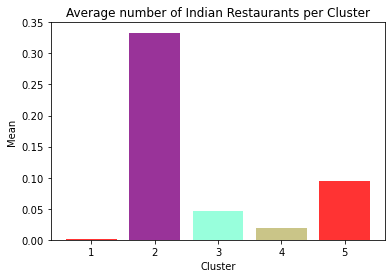

In [71]:
#Filtering and Considering only release ndian Restaurant related information from each of the clusters created above.
clusters_mean = [df_cl1['Indian Restaurant'].mean(),df_cl2['Indian Restaurant'].mean(),df_cl3['Indian Restaurant'].mean(),
                 df_cl4['Indian Restaurant'].mean(),df_cl5['Indian Restaurant'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Indian Restaurants per Cluster')

plt.show()

**Cluster 2** has most of the **Indian Restaurant** followed by **Cluster 5** and **Cluster 3**

## ANALYSIS RESULTS ##



a) **_Downtown Toronto_** Borough has max no of Indian Restaurant in Toronto City

b) **_Downtown Toronto_** Borough has **_10_** Indian Restaurant, where as, **_York_** Borough has least Indian Restaurant preset its count   is only **1** in Toronto City respectively. 

c) **_India Bazaar, The Beaches West_** Neighborhood has maximum no of Indian Restaurant with a count of  **_6_**.

d) We can observe **_Roti Cuisine of India_** of Indian Restaurant got the Maximum Rating.
  It belongs to **_The Annex, North Midtown, Yorkville_** Neighborhood and of **_Central Toronto_** Borough.
   
e) **_Cluster 2_** has most of the **_Indian Restaurant_** followed by **_Cluster 5_** and **_Cluster 3_**